In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd
import sklearn
import numpy as np
from collections import Counter
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pickle
from sklearn.feature_selection import RFE
from sklearn import svm
from xgboost import XGBClassifier
from matplotlib.legend_handler import HandlerLine2D
from matplotlib import rcParams
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold


In [2]:
cnv_types = ['loss', 'gain']
cnv_type = cnv_types[0]

x_train_f = './data_annotsv/train_val_test_sets/train_val_test/x_train_' + cnv_type + '.tsv'
y_train_f = './data_annotsv/train_val_test_sets/train_val_test/y_train_' + cnv_type + '.tsv'
x_val_f = './data_annotsv/train_val_test_sets/train_val_test/x_val_'+ cnv_type + '.tsv'
y_val_f = './data_annotsv/train_val_test_sets/train_val_test/y_val_'+ cnv_type + '.tsv'
x_test_f = './data_annotsv/train_val_test_sets/train_val_test/x_test_' + cnv_type + '.tsv'
y_test_f = './data_annotsv/train_val_test_sets/train_val_test/y_test_'+ cnv_type + '.tsv'

x_train = pd.read_csv(x_train_f, sep='\t')
y_train = pd.read_csv(y_train_f, sep='\t')
x_val = pd.read_csv(x_val_f, sep='\t')
y_val = pd.read_csv(y_val_f, sep='\t')
x_test = pd.read_csv(x_test_f, sep='\t')
y_test = pd.read_csv(y_test_f, sep='\t')

ATTRIBUTES_TO_USE = [
    'morbidGene_count', 
    'min_D_Frequency_3',
    'ExAC_zScore_indel',
    'ExAC_zScore_pLI',
    'HI_DDDperc_haploinsufficient_gene_count',
    'CGscore_indel_gene_count_2', 
    'gene_count',
    'length'
]

if cnv_type == 'gain':
    ATTRIBUTES_TO_USE.remove('HI_DDDperc_haploinsufficient_gene_count')
    ATTRIBUTES_TO_USE.remove('CGscore_indel_gene_count_2')

x_train = x_train[ATTRIBUTES_TO_USE]
x_val = x_val[ATTRIBUTES_TO_USE]
x_test = x_test[ATTRIBUTES_TO_USE]

y_train = y_train.clinsig_bin
y_val = y_val.clinsig_bin
y_test = y_test.clinsig_bin

In [17]:
xgb_clf = XGBClassifier()
xgb_clf.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [5]:
xgb_clf.predict(x_val) 

array([1, 0, 1, ..., 0, 1, 0])

In [6]:
xgb_clf.predict_proba(x_val)

array([[1.6117096e-04, 9.9983883e-01],
       [9.9860382e-01, 1.3962061e-03],
       [4.2319298e-05, 9.9995768e-01],
       ...,
       [9.9490947e-01, 5.0905631e-03],
       [4.5496225e-04, 9.9954504e-01],
       [9.9914712e-01, 8.5287500e-04]], dtype=float32)

In [6]:
xgb_clf = XGBClassifier()
xgb_clf.fit(x_train, y_train)
print('Train_accuracy:', accuracy_score(y_train, xgb_clf.predict(x_train)), 'Train_precision:', metrics.precision_score(y_train, xgb_clf.predict(x_train)))
print('Val_accuracy:', accuracy_score(y_val, xgb_clf.predict(x_val)), 'Val_precision:', metrics.precision_score(y_val, xgb_clf.predict(x_val)))
print('Test_accuracy:', accuracy_score(y_test, xgb_clf.predict(x_test)), 'Test_precision:', metrics.precision_score(y_test, xgb_clf.predict(x_test)))


Train_accuracy: 0.9924134660976767 Train_precision: 0.9944360141628731
Val_accuracy: 0.9657079646017699 Val_precision: 0.945679012345679
Test_accuracy: 0.9728982300884956 Test_precision: 0.9479905437352246


In [9]:
xgb_clf = XGBClassifier()
xgb_clf.fit(x_train, y_train)
print('Train_accuracy:', accuracy_score(y_train, xgb_clf.predict(x_train)), 'Train_precision:', metrics.precision_score(y_train, xgb_clf.predict(x_train)))
print('Val_accuracy:', accuracy_score(y_val, xgb_clf.predict(x_val)), 'Val_precision:', metrics.precision_score(y_val, xgb_clf.predict(x_val)))
print('Test_accuracy:', accuracy_score(y_test, xgb_clf.predict(x_test)), 'Test_precision:', metrics.precision_score(y_test, xgb_clf.predict(x_test)))


Train_accuracy: 0.9848150661689854 Train_precision: 0.9866212600340549
Val_accuracy: 0.9627870150435471 Val_precision: 0.944078947368421
Test_accuracy: 0.9619952494061758 Test_precision: 0.9532497149372862


In [15]:
# Feature importance

In [8]:
xgb_clf = XGBClassifier()
xgb_clf.fit(x_train, y_train)

rfe = RFE(xgb_clf, 1)
rfe = rfe.fit(x_train, y_train)
fi = pd.concat([pd.DataFrame(rfe.ranking_, columns=['RFE_importance']), 
                pd.DataFrame(ATTRIBUTES_TO_USE, columns=['Attribute']), 
                pd.DataFrame(xgb_clf.feature_importances_, columns=['feature_importance'])], axis = 1)
fi = fi.sort_values(by='feature_importance',ascending=False)
fi

/home/gaziova/miniconda3/envs/notebookProjects/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass n_features_to_select=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


,RFE_importance,Attribute,feature_importance
5,2,CGscore_indel_gene_count_2,0.321017
0,1,morbidGene_count,0.244952
7,3,length,0.191918
3,4,ExAC_zScore_pLI,0.102687
1,5,min_D_Frequency_3,0.056643
6,6,gene_count,0.036164
2,7,ExAC_zScore_indel,0.030735
4,8,HI_DDDperc_haploinsufficient_gene_count,0.015885


  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: float or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  contains: unknown
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle or style: {'normal', 'italic', 'oblique'}
  fontvariant or variant: {'normal', 'small-caps'}
  fontw

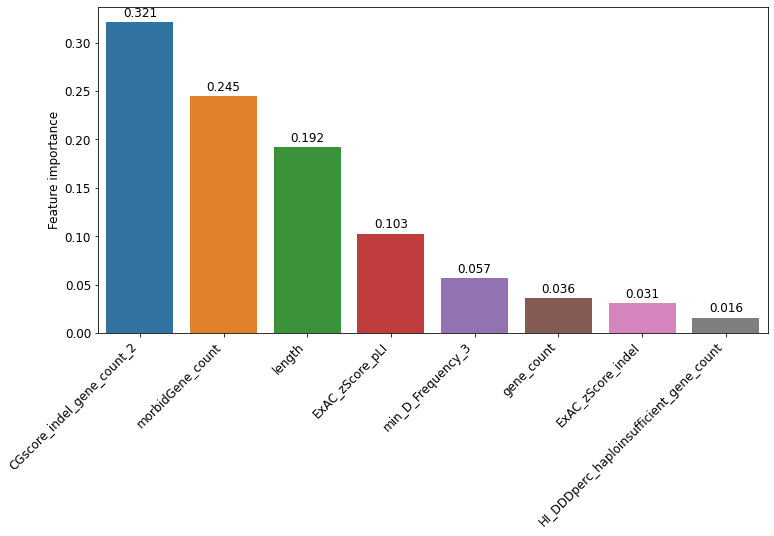

In [14]:
rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(12, 6))

splot = sns.barplot(x='Attribute', y='feature_importance', data =fi)

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.3f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.setp(ax.set_xlabel(''))
plt.setp(ax.set_ylabel('Feature importance'))

In [16]:
# n_estimators

In [3]:
n_estimators = list(range(50, 1500, 50))
train_results = []
validation_results = []

for n in n_estimators:
    model = XGBClassifier(n_estimators=n)
    model.fit(x_train, y_train)
    train_pred = model.predict(x_train)
    acc = accuracy_score(y_train, train_pred)
    train_results.append(acc)
    val_pred = model.predict(x_val)
    acc = accuracy_score(y_val, val_pred)
    validation_results.append(acc)


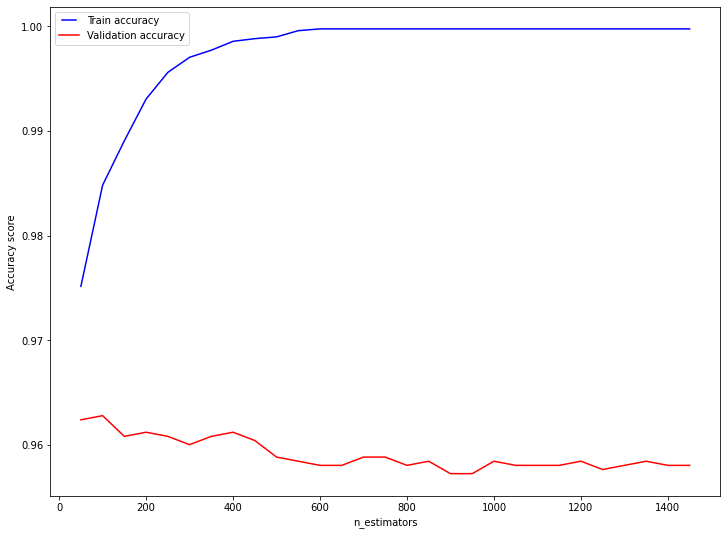

In [4]:
plt.figure(figsize=(12,9))
line1, = plt.plot(n_estimators, train_results, 'b', label='Train accuracy')
line2, = plt.plot(n_estimators, validation_results, 'r', label='Validation accuracy')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy score')
plt.xlabel('n_estimators')
plt.show()

In [18]:
# learning rate (shrinkage factor)

In [22]:
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
train_results = []
validation_results = []

for n in learning_rate:
    model = XGBClassifier(learning_rate=n)
    model.fit(x_train, y_train)
    train_pred = model.predict(x_train)
    acc = accuracy_score(y_train, train_pred)
    train_results.append(acc)
    val_pred = model.predict(x_val)
    acc = accuracy_score(y_val, val_pred)
    validation_results.append(acc)


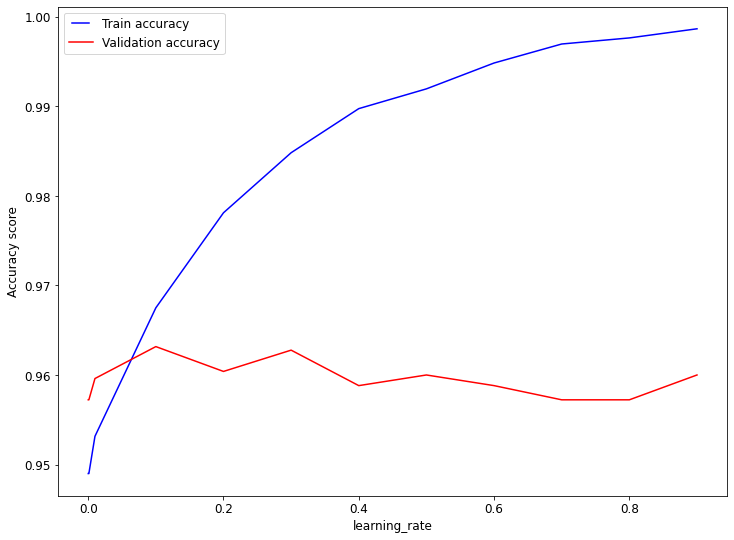

In [23]:
plt.figure(figsize=(12,9))
line1, = plt.plot(learning_rate, train_results, 'b', label='Train accuracy')
line2, = plt.plot(learning_rate, validation_results, 'r', label='Validation accuracy')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy score')
plt.xlabel('learning_rate')
plt.show()

In [29]:
lr = pd.concat([pd.DataFrame(validation_results, columns=['Accuracy_validation']), pd.DataFrame(learning_rate, columns=['learning_rate'])], axis=1)
lr.sort_values(by='Accuracy_validation', ascending=False)

,Accuracy_validation,learning_rate
3,0.963183,0.1000
5,0.962787,0.3000
4,0.960412,0.2000
7,0.960016,0.5000
11,0.960016,0.9000
2,0.959620,0.0100
6,0.958828,0.4000
8,0.958828,0.6000
0,0.957245,0.0001
1,0.957245,0.0010


In [30]:
n_estimators = list(range(50, 600, 50))
train_results = []
validation_results = []

for n in n_estimators:
    model = XGBClassifier(n_estimators=n, learning_rate=0.1)
    model.fit(x_train, y_train)
    train_pred = model.predict(x_train)
    acc = accuracy_score(y_train, train_pred)
    train_results.append(acc)
    val_pred = model.predict(x_val)
    acc = accuracy_score(y_val, val_pred)
    validation_results.append(acc)


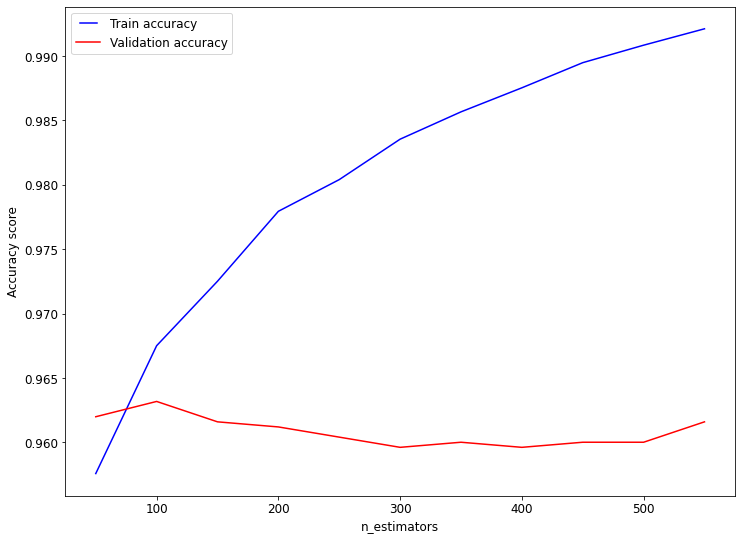

In [32]:
plt.figure(figsize=(12,9))
line1, = plt.plot(n_estimators, train_results, 'b', label='Train accuracy')
line2, = plt.plot(n_estimators, validation_results, 'r', label='Validation accuracy')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy score')
plt.xlabel('n_estimators')
plt.show()

In [31]:
lr2 = pd.concat([pd.DataFrame(validation_results, columns=['Accuracy_validation']), pd.DataFrame(n_estimators, columns=['n_estimators'])], axis=1)
lr2.sort_values(by='Accuracy_validation', ascending=False)

,Accuracy_validation,n_estimators
1,0.963183,100
0,0.961995,50
2,0.961599,150
10,0.961599,550
3,0.961203,200
4,0.960412,250
6,0.960016,350
8,0.960016,450
9,0.960016,500
5,0.959620,300


In [ ]:
# ako sa zlepsilo na testovacom sete?

In [33]:
xgb_clf = XGBClassifier(learning_rate=0.1)
xgb_clf.fit(x_train, y_train)
print('Train_accuracy:', accuracy_score(y_train, xgb_clf.predict(x_train)), 'Train_precision:', metrics.precision_score(y_train, xgb_clf.predict(x_train)))
print('Val_accuracy:', accuracy_score(y_val, xgb_clf.predict(x_val)), 'Val_precision:', metrics.precision_score(y_val, xgb_clf.predict(x_val)))
print('Test_accuracy:', accuracy_score(y_test, xgb_clf.predict(x_test)), 'Test_precision:', metrics.precision_score(y_test, xgb_clf.predict(x_test)))


Train_accuracy: 0.9675093315235833 Train_precision: 0.9714427613608145
Val_accuracy: 0.9631828978622328 Val_precision: 0.9571589627959414
Test_accuracy: 0.9552652414885194 Test_precision: 0.9533799533799534


In [37]:
model = XGBClassifier()
n_estimators = [100, 200, 300, 400, 500]
learning_rate = [0.0001, 0.001, 0.01, 0.1]
param_grid = dict(learning_rate=learning_rate, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(x_train, y_train)

Best:  -0.11251094050649187  using  {'learning_rate': 0.1, 'n_estimators': 200}
-0.6848611602233192 ( 7.464628460864048e-05 ) :  with  {'learning_rate': 0.0001, 'n_estimators': 100}
-0.6767370796597832 ( 0.0001475497743103988 ) :  with  {'learning_rate': 0.0001, 'n_estimators': 200}
-0.668770992415689 ( 0.0002205668453247317 ) :  with  {'learning_rate': 0.0001, 'n_estimators': 300}
-0.6609610125093417 ( 0.00029428000322119697 ) :  with  {'learning_rate': 0.0001, 'n_estimators': 400}
-0.6533017874473057 ( 0.0003688520074308881 ) :  with  {'learning_rate': 0.0001, 'n_estimators': 500}
-0.6170596600293969 ( 0.0007158924167151209 ) :  with  {'learning_rate': 0.001, 'n_estimators': 100}
-0.5537160131368901 ( 0.001355393487347161 ) :  with  {'learning_rate': 0.001, 'n_estimators': 200}
-0.5003606100207525 ( 0.00188067238662667 ) :  with  {'learning_rate': 0.001, 'n_estimators': 300}
-0.45483473039026634 ( 0.0023464775853909363 ) :  with  {'learning_rate': 0.001, 'n_estimators': 400}
-0.41560

Text(0, 0.5, 'Log Loss')

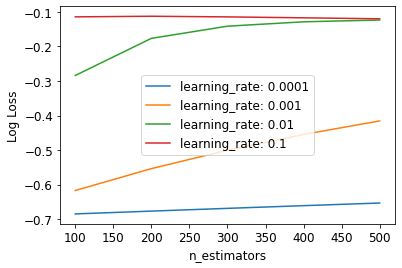

In [43]:
print("Best: ", grid_result.best_score_," using ", grid_result.best_params_)
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print( mean, "(", stdev,") :  with ", param)

    
scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
for i, value in enumerate(learning_rate):
    plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')

In [44]:
xgb_clf = XGBClassifier(learning_rate=0.1, n_estimators=200)
xgb_clf.fit(x_train, y_train)
print('Train_accuracy:', accuracy_score(y_train, xgb_clf.predict(x_train)), 'Train_precision:', metrics.precision_score(y_train, xgb_clf.predict(x_train)))
print('Val_accuracy:', accuracy_score(y_val, xgb_clf.predict(x_val)), 'Val_precision:', metrics.precision_score(y_val, xgb_clf.predict(x_val)))
print('Test_accuracy:', accuracy_score(y_test, xgb_clf.predict(x_test)), 'Test_precision:', metrics.precision_score(y_test, xgb_clf.predict(x_test)))


Train_accuracy: 0.9779436715303699 Train_precision: 0.9778156996587031
Val_accuracy: 0.9612034837688044 Val_precision: 0.9438325991189427
Test_accuracy: 0.9604117181314331 Test_precision: 0.95096921322691
